In [1]:
import utils.eigenstate_generator as eig
import utils.cs_vqe as c
import utils.cs_vqe_ansatz as c_anz
import utils.qubit_conversion as qonvert
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools

In [2]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = '3-21g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (1.1324434021069403+0j) [] +
(-0.025810254414814403+0j) [X0 X1 Y2 Y3] +
(-0.012799934786437282+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.025159645839897615+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.012799934786437279+0j) [X0 X1 X3 X4] +
(-0.025159645839897618+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.01711452882177483+0j) [X0 X1 Y4 Y5] +
(-0.0009891049103631982+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.000989104910363198+0j) [X0 X1 X5 X6] +
(-0.05469856574684973+0j) [X0 X1 Y6 Y7] +
(0.025810254414814403+0j) [X0 Y1 Y2 X3] +
(0.012799934786437282+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(0.025159645839897615+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.012799934786437279+0j) [X0 Y1 Y3 X4] +
(-0.025159645839897618+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.01711452882177483+0j) [X0 Y1 Y4 X5] +
(0.0009891049103631982+0j) [X0 Y1 Y4 Z5 Z6 X7] +
(-0.000989104910363198+0j) [X0 Y1 Y5 X6] +
(0.05469856574684973+0j) [X0 Y1 Y6 X7] +
(0.0025779051794104606+0j) [X0 Z1 X2] +
(0.004766148105680595+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.009264702923307484+0j) [X0 Z1 X2 X3 Z4

UCCSD ansatz: 
 0.006478936130101855j [X0 X1 X2 Y3] +
0.006478936130101855j [X0 X1 Y2 X3] +
0.0020562744029716477j [X0 X1 X4 Y5] +
0.0020562744029716477j [X0 X1 Y4 X5] +
0.005083283191416469j [X0 X1 X6 Y7] +
0.005083283191416469j [X0 X1 Y6 X7] +
-0.006478936130101855j [X0 Y1 X2 X3] +
0.006478936130101855j [X0 Y1 Y2 Y3] +
-0.0020562744029716477j [X0 Y1 X4 X5] +
0.0020562744029716477j [X0 Y1 Y4 Y5] +
-0.005083283191416469j [X0 Y1 X6 X7] +
0.005083283191416469j [X0 Y1 Y6 Y7] +
-0.006360390047790154j [X0 Z1 Y2] +
-0.002645411873732158j [X0 Z1 Z2 Z3 Y4] +
0.0009221551709259922j [X0 Z1 Z2 Z3 Z4 Z5 Y6] +
-0.006478936130101855j [Y0 X1 X2 X3] +
0.006478936130101855j [Y0 X1 Y2 Y3] +
-0.0020562744029716477j [Y0 X1 X4 X5] +
0.0020562744029716477j [Y0 X1 Y4 Y5] +
-0.005083283191416469j [Y0 X1 X6 X7] +
0.005083283191416469j [Y0 X1 Y6 Y7] +
-0.006478936130101855j [Y0 Y1 X2 Y3] +
-0.006478936130101855j [Y0 Y1 Y2 X3] +
-0.0020562744029716477j [Y0 Y1 X4 Y5] +
-0.0020562744029716477j [Y0 Y1 Y4 X5] +
-0.0

In [3]:
#import itertools
#bin_strings = [''.join(s) for s in list(itertools.product(['0','1'], repeat=num_qubits))]

In [4]:
#for b in bin_strings:
#    hf=np.array([0 for i in range(2**num_qubits)])
#    hf[eig.bin_to_int(b)] = 1
#    psi = LinearQubitOperator(ucc_q).matvec(hf)
#    psi_conj = np.conjugate(psi)
#    psi = psi/np.sqrt((psi_conj.dot(psi)))
#    psi_conj = np.conjugate(psi)
#    expect = eig.expectation(ham_q, psi, num_qubits)
#    if expect < -3:
#        print(b, psi_conj.dot(psi), expect)
#print('finished')

In [5]:
ham = qonvert.QubitOperator_to_dict(ham_q, num_qubits)
#anz_terms = list((qonvert.QubitOperator_to_dict(ucc_q, num_qubits)).keys())

#noncontextual hamiltonian
terms_noncon = c.greedy_dfs(ham, 1, criterion='weight')[-1]
ham_noncon = {t:ham[t] for t in terms_noncon}
#contextual hamiltonian
ham_context = {p:c for p,c in ham.items() if p not in ham_noncon}

#construct the epistricted model
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]
generators = {g:gs_noncon[1][0][index] for index, g in enumerate(model[0])}
A = {p:ep_state[1][index] for index, p in enumerate(model[1])}
r1 = ep_state[1][0]
r2 = ep_state[1][1]

#rotate the hamiltonians
rotations = (c.diagonalize_epistemic(model,fn_form,ep_state))[0]
ham, ham_noncon, ham_context = eig.rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)
generators = eig.rotate_operator(rotations, generators)
A = eig.rotate_operator(rotations, A)
ucc = eig.rotate_operator(rotations, ucc)

In [6]:
print('commuting generators:',generators, '\n')
print('anticommuting generators:',A, '\n')
#print('Minimising configuration:', gs_noncon[1])

commuting generators: {'ZIIIIIII': 1.0, 'IZIIIIII': 1.0, 'IIZIIIII': 1.0, 'IIIZIIII': -1.0, 'IIIIZIII': 1.0, 'IIIIIZII': 1.0, 'IIIIIIIZ': 1.0} 

anticommuting generators: {'IZZZZZXI': 0.04017214145305002, 'IIIIIIZI': 0.9991927737184032} 



In [7]:
ham_q = qonvert.dict_to_QubitOperator(ham, num_qubits)
ham_noncon_q = qonvert.dict_to_QubitOperator(ham_noncon, num_qubits)
ham_context_q = qonvert.dict_to_QubitOperator(ham_context, num_qubits)
initial_state='00010000'

#take expectation value algebraically
psi = eig.add_eigenstate(molecule='HeH+', r1=r1, r2=r2, index=16, theta=0, num_qubits=num_qubits, rot=True)
#psi = eig.rotate_state(rotations, psi, num_qubits)
expect = eig.expectation(ham_q, psi, num_qubits)

print('<H> w.r.t. simultaneous eigenstate:', expect)
print('Noncontextual approximation:', gs_noncon_energy)
print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

<H> w.r.t. simultaneous eigenstate: (-3.1428247492681782+0j)
Noncontextual approximation: -3.1428247492681782
Expectation values match? True


In [8]:
qmap = eig.qubit_map('HeH+', num_qubits, rot=True)

In [9]:
qmap_expect=[]
for i in eig.find_eigenstate_indices('00010000', [3, 2, 7]):
    psi = eig.add_eigenstate(molecule='HeH+', r1=r1, r2=r2, index=i, theta=0, num_qubits=num_qubits, rot=True)
    expect = eig.expectation(ham_q, psi, num_qubits)
    qmap_expect.append([expect, qmap[i]])

In [10]:
sorted(qmap_expect, key=lambda x:x[0])

[[(-3.1428247492681782+0j), [(16, '00010000'), (18, '00010010')]],
 [(-3.1413189812838542+0j), [(32, '00100000'), (34, '00100010')]],
 [(-2.8863005917268163+0j), [(0, '00000000'), (2, '00000010')]],
 [(-2.851547766194772+0j), [(48, '00110000'), (50, '00110010')]],
 [(-0.5704922198659778+0j), [(33, '00100001'), (35, '00100011')]],
 [(-0.5268113957537849+0j), [(17, '00010001'), (19, '00010011')]],
 [(-0.29147279190084713+0j), [(49, '00110001'), (51, '00110011')]],
 [(-0.25953545108847204+0j), [(1, '00000001'), (3, '00000011')]]]

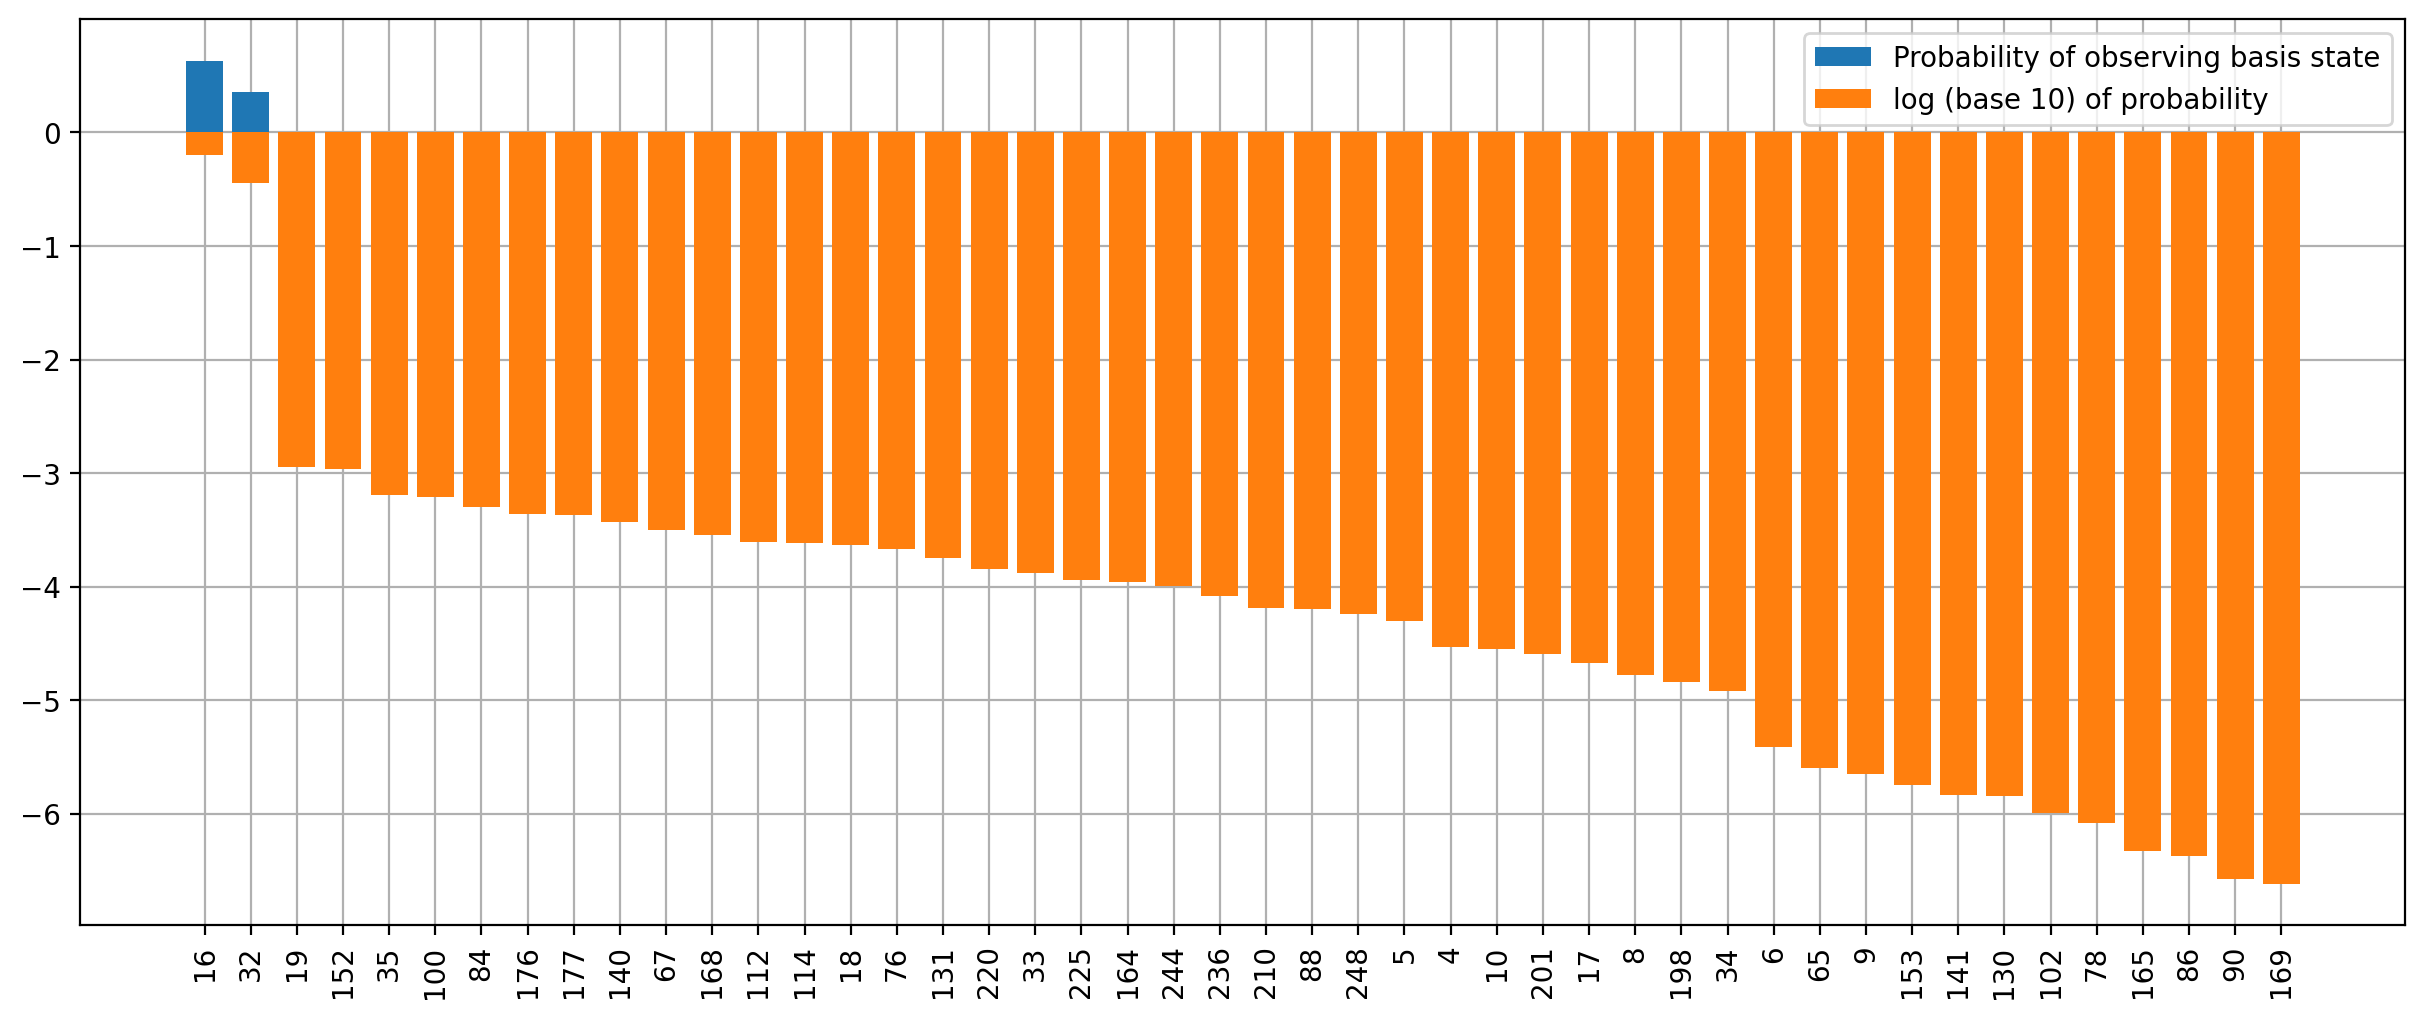

In [11]:
gs = get_ground_state(get_sparse_operator(ham_q, num_qubits).toarray())
true_gs = gs[0]

amp_list = [abs(a)**2 for a in list(gs[1])]
sig_amp_list = sorted([(str(index), a) for index, a in enumerate(amp_list) if a > 10**-7], key=lambda x:x[1])
sig_amp_list.reverse()

XY = list(zip(*sig_amp_list))
X = XY[0]
Y = XY[1]
Y_log = [np.log10(a) for a in Y]

from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=200)

plt.grid(zorder=0)
plt.bar(X, Y, zorder=2, label='Probability of observing basis state')
plt.bar(X, Y_log, zorder=3, label = 'log (base 10) of probability')
plt.xticks(rotation=90)
plt.legend()
plt.show()

[] []


/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


['ZIIIIIII'] [0]
['IZIIIIII', 'ZIIIIIII'] [1, 0]
['IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [2, 1, 0]
['IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [3, 2, 1, 0]
['IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [4, 3, 2, 1, 0]
['IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [5, 4, 3, 2, 1, 0]
['IIIIIIIZ', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [7, 5, 4, 3, 2, 1, 0]


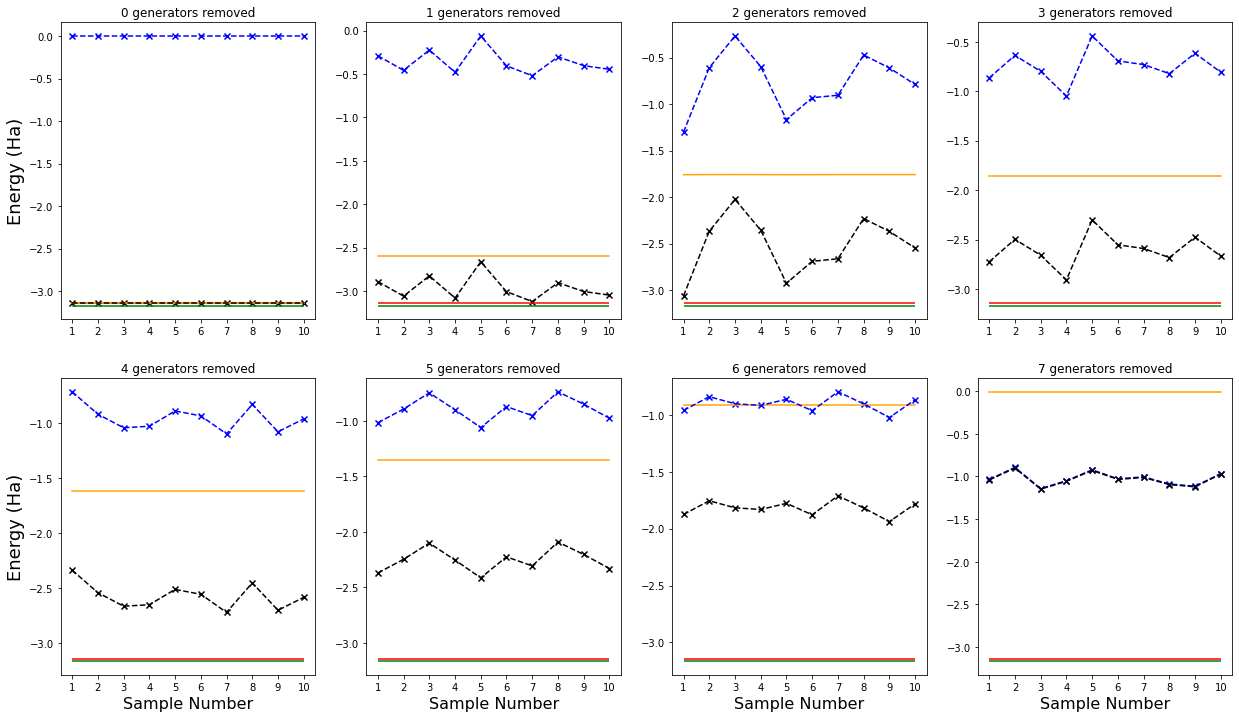

In [12]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=10
#rot_ham, rot_ham_noncon, rot_ham_context = rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)
molecule='HeH+'

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (21,12))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]
#grid_pos.reverse()

X=list(range(1, shots+1))

for index, grid in enumerate(grid_pos):
    
    removed_index = list(range(0, index))
    removed_index.reverse()
    removed_generators = [list(generators.keys())[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    
    new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
    new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon, num_qubits)
    new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context, num_qubits)

    random_amplitudes=[]
    for i in range(shots):  
        rand_vec = eig.random_vector(2**len(removed_index))
        rand_vec = sorted([eig.random_complex_unit()*c for c in rand_vec], key=abs)
        rand_vec.reverse()
        random_amplitudes.append(rand_vec)
        
    Y_noncon=[]
    Y_context=[]
    Y_combined=[]
    Y_full=[]

    #A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
    #A = LinearQubitOperator(A_op, num_qubits)

    for amps in random_amplitudes:
        expect_noncon, expect_context = eig.expectation_optimiser(molecule=molecule, ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
                                                                  r1=r1, r2=r2, amps=amps, initial_state=initial_state,num_qubits=num_qubits,
                                                                  Z_indices=Z_indices,rot=True)

        #Y_full.append(expect_full)
        Y_noncon.append(expect_noncon)
        Y_context.append(expect_context)
        Y_combined.append(expect_noncon+expect_context)

        #print(p, expect_noncon + expect_context < gs_noncon_energy)
        #print((np.conjugate(psi)).dot(psi))
        #Verify +1-eigenstate
        #A_psi = A.matvec(psi)
        #print(psi_conj.dot(A_psi))
    
    axs[grid].plot(X, Y_noncon, color='orange')
    axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    axs[grid].plot(X, Y_context, color='blue', ls='--')
    axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_combined, color='black', ls='--')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, shots, color='r')
    axs[grid].hlines(true_gs, 1, shots, color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index))
    if grid[0] == 1:
        axs[grid].set_xlabel('Sample Number',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [41]:
from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.algorithms import VQE
from qiskit import Aer

amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

anz=QuantumCircuit(num_qubits+1)

anz = c_anz.construct_ansatz(init_state=[4], paulis=list(ucc.keys()))
#anz.x(4)
#anz += c_anz.exp_P('IIIZYIZZI', rot=np.pi/2)

##store parity in auxiliary qubit (8) via CNOT cascade
#anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 8)
##move into +1-eigenstate
#anz.cry(2*t2+0.2, 8, 1)
#anz.x(8)
#anz.cry(2*t2+0.2, 8, 1)
#anz.x(8)
##reverse CNOT cascade
#anz.cx(6, 8),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
#anz.x(1)

anz.measure_all()
#print(anz.draw())
backend = BasicAer.get_backend('qasm_simulator')
job = execute(anz, backend)
plot_histogram(job.result().get_counts(), color='midnightblue', title="New Histogram")

              ░ ┌─────┐┌───┐                                 ┌───┐┌───┐ ░  ░ »
   q_0: ──────░─┤ SDG ├┤ H ├──■───────────────────────────■──┤ H ├┤ S ├─░──░─»
              ░ └─────┘└───┘┌─┴─┐                       ┌─┴─┐└───┘└───┘ ░  ░ »
   q_1: ──────░─────────────┤ X ├──■─────────────────■──┤ X ├───────────░──░─»
              ░  ┌───┐      └───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤           ░  ░ »
   q_2: ──────░──┤ H ├───────────┤ X ├┤ RZ(2*αβγ) ├┤ X ├┤ H ├───────────░──░─»
              ░  └───┘           └───┘└───────────┘└───┘└───┘           ░  ░ »
   q_3: ──────░─────────────────────────────────────────────────────────░──░─»
        ┌───┐ ░                                                         ░  ░ »
   q_4: ┤ X ├─░─────────────────────────────────────────────────────────░──░─»
        └───┘ ░                                                         ░  ░ »
   q_5: ──────░─────────────────────────────────────────────────────────░──░─»
              ░                                     

QiskitError: 'Mismatch between run_config.parameter_binds and all circuit parameters. Parameter binds: [] Circuit parameters: [ParameterView([Parameter(αβγ), Parameter(αβδ), Parameter(αβε), Parameter(αβζ), Parameter(αβη), Parameter(αβθ), Parameter(αβι), Parameter(αβκ), Parameter(αβλ), Parameter(αβμ), Parameter(αβν), Parameter(αβξ), Parameter(αβο), Parameter(αβπ), Parameter(αβρ), Parameter(αβς), Parameter(αβσ), Parameter(αβτ), Parameter(αβυ), Parameter(αβφ), Parameter(αβχ), Parameter(αβψ), Parameter(αβω), Parameter(αγδ), Parameter(αγε), Parameter(αγζ), Parameter(αγη), Parameter(αγθ), Parameter(αγι), Parameter(αγκ), Parameter(αγλ), Parameter(αγμ), Parameter(αγν), Parameter(αγξ), Parameter(αγο), Parameter(αγπ)])]'

In [48]:
removed_generators = ['ZIIIIIII', 'IZIIIIII', 'IIZIIIII','IIIZIIII','IIIIZIII','IIIIIZII', 'IIIIIIIZ']
new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
vqe_input_ham_noncon = qonvert.dict_to_WeightedPauliOperator(new_ham_noncon)
vqe_input_ham_context = qonvert.dict_to_WeightedPauliOperator(new_ham_context)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

slsqp = SLSQP(maxiter=10000)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
"""
amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

anz=QuantumCircuit(num_qubits)

anz.x(4)
anz.rx(Parameter('a'), 7)
anz.rx(Parameter('b'), 6)
anz.rx(Parameter('c'), 5)
anz.rx(Parameter('d'), 4)
anz.rx(Parameter('e'), 3)
anz.rx(Parameter('f'), 2)
anz.rx(Parameter('g'), 0)
#anz.rx(Parameter('b'), 5)

#store parity in auxiliary qubit (8) via CNOT cascade
anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 0)
#move into +1-eigenstate
anz.cry(2*t1, 0, 1)
anz.x(0)
anz.cry(2*t2, 0, 1)
anz.x(0)
#reverse CNOT cascade
anz.cx(6, 0),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
anz.x(1)
"""
ucc_reversed=[]
for p in list(ucc.keys()):
    p_ref = list(deepcopy(p))
    p_ref.reverse()
    ucc_reversed.append(''.join(p_ref))

anz = c_anz.construct_ansatz(init_state=[3], paulis=ucc_reversed)

vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)

vqe_input_ham = qonvert.dict_to_WeightedPauliOperator(ham)
vqe_run = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham)
print('VQE:', vqe_result)
"""
# run VQE on noncontextual hamiltonian to verify we are in +1-eigenspace
vqe_run_noncon = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_noncon)
X_noncon = deepcopy(counts)
Y_noncon = deepcopy(values)
counts.clear(), values.clear()

# run VQE on contextual hamiltonian
vqe_run_context = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_context)
X_context = deepcopy(counts)
Y_context = deepcopy(values)

vqe_result_noncon = vqe_run_noncon.optimal_value
vqe_result_context = vqe_run_context.optimal_value
vqe_result = vqe_result_noncon + vqe_result_context
"""
#print('VQE:', vqe_result_noncon,'+', vqe_result_context,'=', vqe_result, '|', 'Improves noncontextual estimate?', vqe_result<gs_noncon_energy)

VQE: -3.1428246129595565


'\n# run VQE on noncontextual hamiltonian to verify we are in +1-eigenspace\nvqe_run_noncon = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_noncon)\nX_noncon = deepcopy(counts)\nY_noncon = deepcopy(values)\ncounts.clear(), values.clear()\n\n# run VQE on contextual hamiltonian\nvqe_run_context = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_context)\nX_context = deepcopy(counts)\nY_context = deepcopy(values)\n\nvqe_result_noncon = vqe_run_noncon.optimal_value\nvqe_result_context = vqe_run_context.optimal_value\nvqe_result = vqe_result_noncon + vqe_result_context\n'

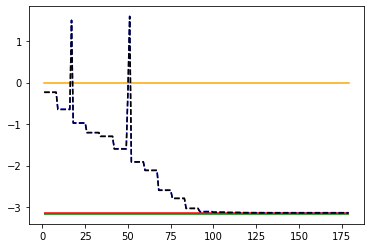

In [15]:
X=X_context
conv_diff = len(X_context) - len(X_noncon)

if conv_diff < 0:
    Y_noncon = Y_noncon[0:len(X)]
else:
    for i in range(conv_diff):
        Y_noncon.append(Y_noncon[-1])

Y_total = [sum(x) for x in zip(Y_noncon, Y_context)]

plt.plot(X, Y_noncon, color='orange')
#plt.scatter(X, Y_context, color='blue', marker = 'x')
plt.plot(X, Y_context, color='blue', ls='--')
#plt.scatter(X, Y_total, color='black', marker = 'x')
plt.plot(X, Y_total, color='black', ls='--')

plt.hlines(gs_noncon_energy, 1, len(X), color='r')
plt.hlines(true_gs, 1, len(X), color='g')

In [16]:
ucc_fix_q1 = []
for p in ucc.keys():
    p_list = list(p)
    #p_list[6] = 'I'
    #p_list[7] = 'I'
    p_list.reverse()
    ucc_fix_q1.append(''.join(p_list))
print(ucc_fix_q1)

['ZIIIIXZY', 'ZZIIIYZX', 'IIIIXYYY', 'ZIIIYYXY', 'ZZIIXYXX', 'IZIIYYYX', 'ZIIIXXXY', 'IIIIYXYY', 'IZIIXXYX', 'ZZIIYXXX', 'IIIIXZYI', 'ZIIIYZXI', 'ZIIXZZZY', 'ZZIYZZZX', 'IIXYIIYY', 'ZIYYIIXY', 'ZZXYIIXX', 'IZYYIIYX', 'ZIXXIIXY', 'IIYXIIYY', 'IZXXIIYX', 'ZZYXIIXX', 'IIXZZZYI', 'ZIYZZZXI', 'ZYZZZZZI', 'ZYZZZZZZ', 'YXIIIIII', 'YXIIIIZI', 'XYIIIIZZ', 'XYIIIIIZ', 'XYIIIIZI', 'XYIIIIII', 'YXIIIIIZ', 'YXIIIIZZ', 'YZZZZZII', 'YZZZZZZI']


Removed generators: [] []
VQE result: -3.14282474926818 Improvement? True | Noncontextual: -3.1428247492681782 True: -3.1667654772544167
Removed generators: ['ZIIIIIII'] [7]
VQE result: -3.1428247492301997 Improvement? False | Noncontextual: -3.1428247492681782 True: -3.1667654772544167
Removed generators: ['IZIIIIII', 'ZIIIIIII'] [6, 7]
VQE result: -3.1427991165547637 Improvement? False | Noncontextual: -3.1428247492681782 True: -3.1667654772544167
Removed generators: ['IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [5, 6, 7]
VQE result: -3.1428245271543758 Improvement? False | Noncontextual: -3.1428247492681782 True: -3.1667654772544167
Removed generators: ['IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [4, 5, 6, 7]
VQE result: -3.142799771345086 Improvement? False | Noncontextual: -3.1428247492681782 True: -3.1667654772544167
Removed generators: ['IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'] [3, 4, 5, 6, 7]
VQE result: -3.1413189660659704 Improvement? False | Noncontextual: -3.14

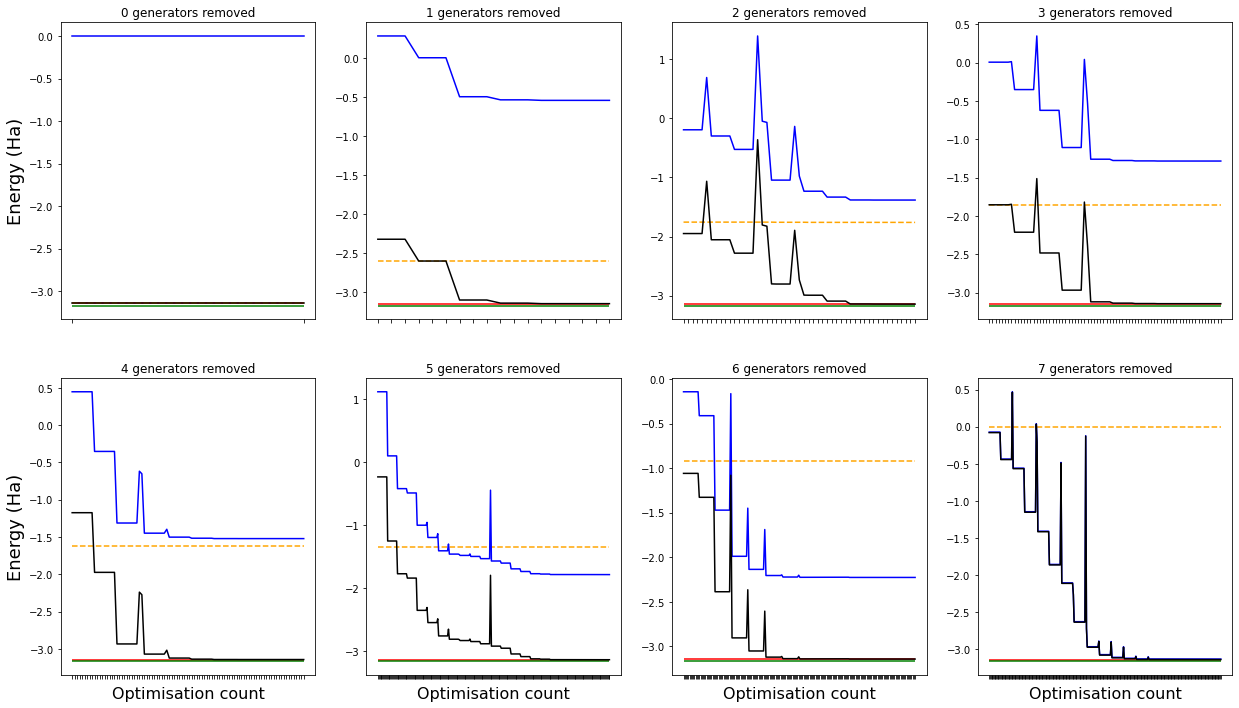

In [39]:
#VQE setup
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
slsqp = SLSQP(maxiter=10000)
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# create blank plot
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (21,12))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(1,0),(1,1),(1,2),(1,3)]

# compute +1-eigenspace quotient
amp_ratio = (1 + r2) / (r1)
t1 = np.arctan(-amp_ratio)
t2 = np.arctan(+amp_ratio)

# create blank parameters to assign in circuit for VQE optimsisation
param_chars = ['α','β','γ','δ','ε','ζ','η','θ','ι','κ','λ','μ','ν','ξ','ο','π','ρ','ς','σ','τ','υ','φ','χ','ψ','ω']
params = [] 
for comb in list(itertools.combinations(param_chars, 2)):
    char_str = ''.join(comb)
    params.append(Parameter(char_str))

#discard generators left to right whilst performing VQE
for index, grid in enumerate(grid_pos):
    
    removed_index = list(range(0, index))
    removed_index.reverse()
    removed_generators = [list(generators.keys())[i] for i in removed_index]
    Z_indices = [7 - g.find('Z') for g in removed_generators]
    
    print('Removed generators:', removed_generators, Z_indices)

    new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
    new_ham_noncon_add_q8={}
    new_ham_context_add_q8={}
    for p in new_ham_noncon.keys():
        p_add_q = 'I' + p
        new_ham_noncon_add_q8[p_add_q] = new_ham_noncon[p]
    for p in new_ham_context.keys():
        p_add_q = 'I' + p
        new_ham_context_add_q8[p_add_q] = new_ham_context[p]
    
    vqe_input_ham_noncon = qonvert.dict_to_WeightedPauliOperator(new_ham_noncon_add_q8)
    vqe_input_ham_context = qonvert.dict_to_WeightedPauliOperator(new_ham_context_add_q8)
    
    # initiate blank circuit
    anz=QuantumCircuit(num_qubits + 1)
    
    # noncontextual reference
    anz.x(4)

    # search over space not fixed by generators
    if Z_indices == []:
        anz.rz(params[0], 4) # because VQE needs at least one parameter...
    else:
        param_index = 0
        over_P = ['I' for i in range(num_qubits+1)]
        for z in Z_indices:
            blank_P = ['I' for i in range(num_qubits+1)]
            blank_P[z] = 'X'
            over_P[z] = 'X'
            anz += c_anz.exp_P(''.join(blank_P), rot = params[param_index])
            anz += c_anz.exp_P(''.join(over_P), rot = params[param_index+1])
            param_index += 2
            
        #ucc_fix = []
        #Z_complement = list(set(range(num_qubits)) - set(Z_indices))
        ##print(Z_complement)
        #for p in ucc.keys():
        #    p_list = list(deepcopy(p))
        #    p_list.reverse()
        #    #p_list[6] = 'I'
        #    #p_list[7] = 'I'
        #    for z in Z_complement:     
        #        p_list[z] = 'I'
        #    ucc_fix.append(''.join(p_list) + 'I')
        #    #print(p_list)
        ##print(ucc_fix)
        
        #anz = c_anz.construct_ansatz(paulis=ucc_fix, circ=anz)
        #anz += c_anz.exp_P('IIIYYIII', rot = Parameter('a'))
        
    # store parity in auxiliary qubit (8) via CNOT cascade
    anz.cx(2, 3),anz.cx(3, 4),anz.cx(4, 5),anz.cx(5, 6),anz.cx(6, 8)
    # move into +1-eigenspace
    anz.cry(2*t1, 8, 1)
    anz.x(8)
    anz.cry(2*t2, 8, 1)
    anz.x(8)
    # reverse CNOT cascade
    anz.cx(6, 8),anz.cx(5, 6), anz.cx(4, 5), anz.cx(3, 4), anz.cx(2, 3)
    anz.x(1)
    #print(anz.draw())
    
    # create VQE routine
    vqe = VQE(anz, optimizer=slsqp, callback=store_intermediate_result, quantum_instance=qi)

    # run VQE on noncontextual hamiltonian to verify we are in +1-eigenspace
    vqe_run_noncon = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_noncon)
    X_noncon = deepcopy(counts)
    Y_noncon = deepcopy(values)
    counts.clear(), values.clear()

    # run VQE on contextual hamiltonian
    vqe_run_context = vqe.compute_minimum_eigenvalue(operator=vqe_input_ham_context)
    X_context = deepcopy(counts)
    Y_context = deepcopy(values)
    counts.clear(), values.clear()
    
    # increase or decrease size of Y_noncon to match Y_context
    X=X_context
    conv_diff = len(X_context) - len(X_noncon)
    if conv_diff < 0:
        Y_noncon = Y_noncon[0:len(X)]
    else:
        for i in range(conv_diff):
            Y_noncon.append(Y_noncon[-1])
    
    # combined approximation
    Y_total = [sum(x) for x in zip(Y_noncon, Y_context)]
    print('VQE result:', Y_total[-1], 'Improvement?', Y_total[-1]<gs_noncon_energy, '|', 'Noncontextual:', gs_noncon_energy, 'True:', true_gs)
            
    # plot results in corresponding subfigure
    axs[grid].plot(X, Y_noncon, color='orange',ls='--')
    #axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    axs[grid].plot(X, Y_context, color='blue')
    #axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_total, color='black')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, len(X), color='r')
    axs[grid].hlines(true_gs, 1, len(X), color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index))
    axs[grid].set_xticklabels([])
    if grid[0] == 1:
        axs[grid].set_xlabel('Optimisation count',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [35]:
print(vqe_run_context)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 536,
    'eigenstate': array([ 5.66112707e-17-1.11859573e-16j,  8.37909151e-17+1.88855047e-13j,
        1.13755712e-18-2.24772651e-18j,  1.68370981e-18+3.79488749e-15j,
       -7.52748993e-09+5.74242948e-16j,  3.81347229e-17+7.88995048e-13j,
        1.51258745e-10-1.15389417e-17j, -7.66286023e-19-1.58542093e-14j,
       -7.92257033e-09+1.04930421e-16j,  1.46297557e-16-7.55856843e-05j,
        1.59197562e-10-2.10849086e-18j, -2.93972959e-18+1.51883242e-06j,
       -1.89438163e-09+1.03200866e-16j, -1.36456115e-16+1.98588348e-13j,
       -3.80660474e-11+2.07373689e-18j, -2.74197387e-18+3.99047021e-15j,
        2.62643642e-09+1.56109596e-15j, -4.53698641e-16+2.50576470e-05j,
       -5.27760888e-11-3.13689448e-17j,  9.11670261e-18-5.03512895e-07j,
       -9.99798159e-01+9.06828760e-15j,  2.58779294e-17+1.04794596e-04j,
       -2.00901252e-02+1.82219812e-16j,  5.19995797e-19+2.10576159e-06j,
        1.04363715e-08+1.43091697e-1

In [18]:
fig.savefig("plots/HeH+-generator-removal-energies-VQE-naive_ansatz.png", dpi=300)

In [19]:
for index, r in enumerate(rotations):
    rotations[index][0] = np.pi/4
print(rotations)

[[0.7853981633974483, 'YIIIIIII'], [0.7853981633974483, 'YIIIIIZI'], [0.7853981633974483, 'IYIIIIII'], [0.7853981633974483, 'IYIIIIIZ']]


In [20]:
help(eig.expectation)

Help on function expectation in module utils.eigenstate_generator:

expectation(op, state, num_qubits)



In [21]:
ucc_param={}
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
import itertools
param_chars = ['α','β','γ','δ','ε','ζ','η','θ','ι','κ','λ','μ','ν','ξ','ο','π','ρ','ς','σ','τ','υ','φ','χ','ψ','ω']
params = [] 
for comb in list(itertools.combinations(param_chars, 2)):
    char_str = ''.join(comb)
    params.append(Parameter(char_str))

for index, p in enumerate(ucc.keys()):
    ucc_param[p] = params[index]
    
qonvert.dict_to_QubitOperator(ucc_param, num_qubits)

ValueError: Coefficient must be a numeric type.

In [ ]:
qonvert.dict_to_QubitOperator(ucc_param, num_qubits)

In [ ]:
anz = c_anz.construct_ansatz(init_state=[0,1,2,3], paulis=list(ucc.keys()))

In [26]:
string= 'abcde'
string.reverse()
string

AttributeError: 'str' object has no attribute 'reverse'

In [ ]:
sorted([8, 3, 6, 9]).reverse()

In [ ]:
new_ham_noncon